<a href="https://colab.research.google.com/github/nfrn/ComputerVisionHandsOn/blob/main/Forma%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Recolha de Dados


In [1]:
!git clone https://github.com/nfrn/ComputerVisionHandsOn.git
!unzip /content/ComputerVisionHandsOn/maskdataset.zip -d ComputerVisionHandsOn

Cloning into 'ComputerVisionHandsOn'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.
Archive:  /content/ComputerVisionHandsOn/maskdataset.zip
 extracting: ComputerVisionHandsOn/test/w1240-p16x9-2019-10-04t075956z_1862636027_rc15d4d49d00_rtrmadp_3_hongkong-protests_jpg.rf.a9a2c2a1cb13c980b339065d2324ea7d.jpg  
 extracting: ComputerVisionHandsOn/train/11893820-3x2-xlarge_jpg.rf.1529b09bfee7d069f677ff513f6249eb.jpg  
 extracting: ComputerVisionHandsOn/train/130624011830-malaysia-smog-students-horizontal-large-gallery_jpg.rf.1d1478ec7b2667aa240401f636d513c4.jpg  
 extracting: ComputerVisionHandsOn/test/126202-untitled-design-13_jpg.rf.baa3d2e55d469ae5d5d4cd81c4603e1d.jpg  
 extracting: ComputerVisionHandsOn/test/r1p00017o8171pnq407_jpg.rf.d21dd91220d3df7763f7d572f3d95863.jpg  
 extracting: ComputerVisio

# Visualizacao dos Dados

In [2]:
import base64
import IPython
import json
import numpy as np
import os
import random
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

In [9]:
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                        'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                        'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                        'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        #self.process_info()
        #self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()

    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')
        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_labels=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        print(self.images)
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = "data:image/png;base64, " + base64.b64encode(buffered.getvalue()).decode()
        
        # Calculate the size and adjusted display size
        max_width = 900
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        labels = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))

            polygons[segm['id']] = polygons_list

            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            labels[segm['id']] = (self.categories[segm['category_id']]['name'], (bbox_points[0], bbox_points[1] - 4))
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))

        # Draw segmentation polygons on image
        html = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(img_str, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        if show_labels:
            for seg_id, label in labels.items():
                color = poly_colors[seg_id]
                html += '<text x="{}" y="{}" style="fill:{}; font-size: 12pt;">{}</text>'.format(label[1][0], label[1][1], color, label[0])
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [13]:
annotation_path = r'/content/ComputerVisionHandsOn/train/_annotations.coco.json'
image_dir = r'/content/ComputerVisionHandsOn/train'

coco_dataset = CocoDataset(annotation_path, image_dir)
html = coco_dataset.display_image(1, use_url=False)
IPython.display.HTML(html)

Image:
{0: {'id': 0, 'license': 1, 'file_name': '11893820-3x2-xlarge_jpg.rf.1529b09bfee7d069f677ff513f6249eb.jpg', 'height': 575, 'width': 862, 'date_captured': '2020-09-20T23:43:09+00:00'}, 1: {'id': 1, 'license': 1, 'file_name': '130624011830-malaysia-smog-students-horizontal-large-gallery_jpg.rf.1d1478ec7b2667aa240401f636d513c4.jpg', 'height': 552, 'width': 980, 'date_captured': '2020-09-20T23:43:09+00:00'}, 2: {'id': 2, 'license': 1, 'file_name': '1125506397_15801322206131n_jpg.rf.0a60284a71b2d0ed77c002e768b39b00.jpg', 'height': 630, 'width': 900, 'date_captured': '2020-09-20T23:43:09+00:00'}, 3: {'id': 3, 'license': 1, 'file_name': 'upload-productImg-1527496119162_320_234_jpeg.rf.2630f815b6cc48c80dd42bf539300d26.jpg', 'height': 600, 'width': 600, 'date_captured': '2020-09-20T23:43:09+00:00'}, 4: {'id': 4, 'license': 1, 'file_name': '1249493_jpg.rf.0bab72e6f8295a2ba03052383e7c3b7b.jpg', 'height': 645, 'width': 1012, 'date_captured': '2020-09-20T23:43:09+00:00'}, 5: {'id': 5, 'licen

# Download do Modelo Original

In [2]:
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 27.03 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.
     |████████████████████████████████| 352.6 MB 13 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-py3-none-any.whl size=17463 sha256=37b618b468ab9ca4bf296756000a5da001036cbe3cf1383f5bdb2dc9ce39c8c6
  Stored in directory: /root/.cache/pip/wheels/18/44/5a/c7b93703f611ae3b50820efbaf265413e6b183a56cbec6f661
Successfully built dicttoxml
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-93oeppf3/pycocotools_91cbb0c76e3c46c99b5cbf58f2571304
  Running command git clone -q https://github.com/abhi-kumar

In [3]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

     \ 91 kB 1.2 MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47878 sha256=d9b81c11e562da457f8ff0a33ce5d28da363fc0987a8a5bbd19e6fd57f85a6fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-rp1vd6k2/wheels/b5/36/d9/593e7ac06d343d0a32138fa6c402dc3a0bd31442c9fe53f76c
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.28.1 which is incompatible.
fbprophet 0.7.1 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl

# Re-estruturar Pastas

In [4]:
!mkdir Masks
!mkdir Masks/Train
!mkdir Masks/Train/annotations
!mkdir Masks/Train/Annotations
!mkdir Masks/Train/Images

!mkdir Masks/Validation
!mkdir Masks/Validation/annotations
!mkdir Masks/Validation/Annotations
!mkdir Masks/Validation/Images

!mkdir Masks/Test
!mkdir Masks/Test/annotations
!mkdir Masks/Test/Annotations
!mkdir Masks/Test/Images

In [ ]:
%ls

In [5]:
%cp ComputerVisionHandsOn/train/_annotations.coco.json Masks/Train/annotations/instances_Images.json
%cp ComputerVisionHandsOn/train/*.jpg Masks/Train/Images/

%cp ComputerVisionHandsOn/valid/_annotations.coco.json Masks/Validation/annotations/instances_Images.json
%cp ComputerVisionHandsOn/valid/*.jpg Masks/Validation/Images/

%cp ComputerVisionHandsOn/test/_annotations.coco.json Masks/Test/annotations/instances_Images.json
%cp ComputerVisionHandsOn/test/*.jpg Masks/Test/Images/

In [6]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

# Configurações de Treino

In [7]:
from train_detector import Detector

In [8]:
gtf = Detector();

In [9]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Masks/Train";
img_dir = "./";
set_dir = "Images"; 
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Masks/Validation";
img_dir = "./";
set_dir = "Images"; 
gtf.Val_Dataset(root_dir, coco_dir, img_dir, set_dir) 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
gtf.Model();

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [12]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [13]:
%%time
gtf.Train(num_epochs=10, model_output_dir="trained/");

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/10. Iteration: 1/13. Cls loss: 1.12938. Reg loss: 1.06400. Batch loss: 2.19338 Total loss: 2.19338
Epoch: 1/10. Iteration: 2/13. Cls loss: 1.12387. Reg loss: 1.02558. Batch loss: 2.14945 Total loss: 2.17141
Epoch: 1/10. Iteration: 3/13. Cls loss: 1.11753. Reg loss: 1.05278. Batch loss: 2.17031 Total loss: 2.17105
Epoch: 1/10. Iteration: 4/13. Cls loss: 1.10918. Reg loss: 1.01214. Batch loss: 2.12132 Total loss: 2.15861
Epoch: 1/10. Iteration: 5/13. Cls loss: 1.10193. Reg loss: 1.04608. Batch loss: 2.14801 Total loss: 2.15649
Epoch: 1/10. Iteration: 6/13. Cls loss: 1.09278. Reg loss: 1.02788. Batch loss: 2.12066 Total loss: 2.15052
Epoch: 1/10. Iteration: 7/13. Cls loss: 1.08287. Reg loss: 0.98813. Batch loss: 2.07100 Total loss: 2.13916
Epoch: 1/10. Iteration: 8/13. Cls loss: 1.06881. Reg loss: 0.98538. Batch loss: 2.05420 Total loss: 2.12854
Epoch: 1/10. Iteration: 9/13. Cls loss: 1.05553. Reg loss: 1.00814. Batch loss: 2.06367 Total loss: 2.12133
Epoch: 1/10. Iteration: 10/1

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might caus

Epoch: 2/10. Iteration: 1/13. Cls loss: 0.93601. Reg loss: 0.94843. Batch loss: 1.88444 Total loss: 1.88444
Epoch: 2/10. Iteration: 2/13. Cls loss: 0.90529. Reg loss: 0.92742. Batch loss: 1.83271 Total loss: 1.85857
Epoch: 2/10. Iteration: 3/13. Cls loss: 0.85473. Reg loss: 0.92146. Batch loss: 1.77619 Total loss: 1.83111
Epoch: 2/10. Iteration: 4/13. Cls loss: 0.82546. Reg loss: 0.90248. Batch loss: 1.72794 Total loss: 1.80532
Epoch: 2/10. Iteration: 5/13. Cls loss: 0.75149. Reg loss: 0.88145. Batch loss: 1.63294 Total loss: 1.77084
Epoch: 2/10. Iteration: 6/13. Cls loss: 0.72778. Reg loss: 0.91358. Batch loss: 1.64136 Total loss: 1.74926
Epoch: 2/10. Iteration: 7/13. Cls loss: 0.65004. Reg loss: 0.89578. Batch loss: 1.54582 Total loss: 1.72020
Epoch: 2/10. Iteration: 8/13. Cls loss: 0.68492. Reg loss: 0.90732. Batch loss: 1.59224 Total loss: 1.70420
Epoch: 2/10. Iteration: 9/13. Cls loss: 0.66310. Reg loss: 0.92944. Batch loss: 1.59254 Total loss: 1.69180
Epoch: 2/10. Iteration: 10/1

Epoch: 3/10. Iteration: 1/13. Cls loss: 0.61421. Reg loss: 0.87938. Batch loss: 1.49360 Total loss: 1.49360
Epoch: 3/10. Iteration: 2/13. Cls loss: 0.59727. Reg loss: 0.88711. Batch loss: 1.48438 Total loss: 1.48899
Epoch: 3/10. Iteration: 3/13. Cls loss: 0.67699. Reg loss: 0.92606. Batch loss: 1.60305 Total loss: 1.52701
Epoch: 3/10. Iteration: 4/13. Cls loss: 0.55593. Reg loss: 0.88988. Batch loss: 1.44580 Total loss: 1.50671
Epoch: 3/10. Iteration: 5/13. Cls loss: 0.54101. Reg loss: 0.88725. Batch loss: 1.42826 Total loss: 1.49102
Epoch: 3/10. Iteration: 6/13. Cls loss: 0.57815. Reg loss: 0.86699. Batch loss: 1.44514 Total loss: 1.48337
Epoch: 3/10. Iteration: 7/13. Cls loss: 0.56292. Reg loss: 0.86599. Batch loss: 1.42891 Total loss: 1.47559
Epoch: 3/10. Iteration: 8/13. Cls loss: 0.49542. Reg loss: 0.89916. Batch loss: 1.39458 Total loss: 1.46546
Epoch: 3/10. Iteration: 9/13. Cls loss: 0.55189. Reg loss: 0.87254. Batch loss: 1.42444 Total loss: 1.46091
Epoch: 3/10. Iteration: 10/1

Epoch: 4/10. Iteration: 1/13. Cls loss: 0.46847. Reg loss: 0.86899. Batch loss: 1.33746 Total loss: 1.33746
Epoch: 4/10. Iteration: 2/13. Cls loss: 0.53015. Reg loss: 0.88057. Batch loss: 1.41072 Total loss: 1.37409
Epoch: 4/10. Iteration: 3/13. Cls loss: 0.48220. Reg loss: 0.86445. Batch loss: 1.34665 Total loss: 1.36495
Epoch: 4/10. Iteration: 4/13. Cls loss: 0.49351. Reg loss: 0.87920. Batch loss: 1.37271 Total loss: 1.36689
Epoch: 4/10. Iteration: 5/13. Cls loss: 0.52862. Reg loss: 0.87956. Batch loss: 1.40817 Total loss: 1.37514
Epoch: 4/10. Iteration: 6/13. Cls loss: 0.50075. Reg loss: 0.84937. Batch loss: 1.35012 Total loss: 1.37097
Epoch: 4/10. Iteration: 7/13. Cls loss: 0.50066. Reg loss: 0.81075. Batch loss: 1.31141 Total loss: 1.36247
Epoch: 4/10. Iteration: 8/13. Cls loss: 0.47904. Reg loss: 0.87599. Batch loss: 1.35503 Total loss: 1.36154
Epoch: 4/10. Iteration: 9/13. Cls loss: 0.45462. Reg loss: 0.88105. Batch loss: 1.33567 Total loss: 1.35866
Epoch: 4/10. Iteration: 10/1

Epoch: 5/10. Iteration: 1/13. Cls loss: 0.44670. Reg loss: 0.82271. Batch loss: 1.26941 Total loss: 1.26941
Epoch: 5/10. Iteration: 2/13. Cls loss: 0.46633. Reg loss: 0.84434. Batch loss: 1.31067 Total loss: 1.29004
Epoch: 5/10. Iteration: 3/13. Cls loss: 0.43074. Reg loss: 0.85936. Batch loss: 1.29010 Total loss: 1.29006
Epoch: 5/10. Iteration: 4/13. Cls loss: 0.47855. Reg loss: 0.84336. Batch loss: 1.32192 Total loss: 1.29803
Epoch: 5/10. Iteration: 5/13. Cls loss: 0.44690. Reg loss: 0.82715. Batch loss: 1.27405 Total loss: 1.29323
Epoch: 5/10. Iteration: 6/13. Cls loss: 0.47682. Reg loss: 0.82523. Batch loss: 1.30206 Total loss: 1.29470
Epoch: 5/10. Iteration: 7/13. Cls loss: 0.40669. Reg loss: 0.83243. Batch loss: 1.23912 Total loss: 1.28676
Epoch: 5/10. Iteration: 8/13. Cls loss: 0.43384. Reg loss: 0.79891. Batch loss: 1.23275 Total loss: 1.28001
Epoch: 5/10. Iteration: 9/13. Cls loss: 0.40408. Reg loss: 0.79996. Batch loss: 1.20404 Total loss: 1.27157
Epoch: 5/10. Iteration: 10/1

Epoch: 6/10. Iteration: 1/13. Cls loss: 0.42386. Reg loss: 0.78959. Batch loss: 1.21345 Total loss: 1.21345
Epoch: 6/10. Iteration: 2/13. Cls loss: 0.39109. Reg loss: 0.79923. Batch loss: 1.19032 Total loss: 1.20189
Epoch: 6/10. Iteration: 3/13. Cls loss: 0.51653. Reg loss: 0.76125. Batch loss: 1.27777 Total loss: 1.22718
Epoch: 6/10. Iteration: 4/13. Cls loss: 0.36945. Reg loss: 0.76617. Batch loss: 1.13562 Total loss: 1.20429
Epoch: 6/10. Iteration: 5/13. Cls loss: 0.46468. Reg loss: 0.76078. Batch loss: 1.22546 Total loss: 1.20853
Epoch: 6/10. Iteration: 6/13. Cls loss: 0.37982. Reg loss: 0.71529. Batch loss: 1.09510 Total loss: 1.18962
Epoch: 6/10. Iteration: 7/13. Cls loss: 0.42992. Reg loss: 0.77183. Batch loss: 1.20175 Total loss: 1.19135
Epoch: 6/10. Iteration: 8/13. Cls loss: 0.42704. Reg loss: 0.78809. Batch loss: 1.21513 Total loss: 1.19433
Epoch: 6/10. Iteration: 9/13. Cls loss: 0.37268. Reg loss: 0.76410. Batch loss: 1.13678 Total loss: 1.18793
Epoch: 6/10. Iteration: 10/1

Epoch: 7/10. Iteration: 1/13. Cls loss: 0.41657. Reg loss: 0.75584. Batch loss: 1.17242 Total loss: 1.17242
Epoch: 7/10. Iteration: 2/13. Cls loss: 0.39561. Reg loss: 0.70759. Batch loss: 1.10320 Total loss: 1.13781
Epoch: 7/10. Iteration: 3/13. Cls loss: 0.40722. Reg loss: 0.72705. Batch loss: 1.13427 Total loss: 1.13663
Epoch: 7/10. Iteration: 4/13. Cls loss: 0.38499. Reg loss: 0.70024. Batch loss: 1.08522 Total loss: 1.12378
Epoch: 7/10. Iteration: 5/13. Cls loss: 0.36814. Reg loss: 0.66970. Batch loss: 1.03784 Total loss: 1.10659
Epoch: 7/10. Iteration: 6/13. Cls loss: 0.36273. Reg loss: 0.69505. Batch loss: 1.05778 Total loss: 1.09846
Epoch: 7/10. Iteration: 7/13. Cls loss: 0.37487. Reg loss: 0.70995. Batch loss: 1.08483 Total loss: 1.09651
Epoch: 7/10. Iteration: 8/13. Cls loss: 0.37700. Reg loss: 0.64775. Batch loss: 1.02475 Total loss: 1.08754
Epoch: 7/10. Iteration: 9/13. Cls loss: 0.34580. Reg loss: 0.68073. Batch loss: 1.02653 Total loss: 1.08076
Epoch: 7/10. Iteration: 10/1

Epoch: 8/10. Iteration: 1/13. Cls loss: 0.30690. Reg loss: 0.60149. Batch loss: 0.90840 Total loss: 0.90840
Epoch: 8/10. Iteration: 2/13. Cls loss: 0.35474. Reg loss: 0.65356. Batch loss: 1.00830 Total loss: 0.95835
Epoch: 8/10. Iteration: 3/13. Cls loss: 0.32932. Reg loss: 0.61935. Batch loss: 0.94867 Total loss: 0.95512
Epoch: 8/10. Iteration: 4/13. Cls loss: 0.29378. Reg loss: 0.59386. Batch loss: 0.88764 Total loss: 0.93825
Epoch: 8/10. Iteration: 5/13. Cls loss: 0.33885. Reg loss: 0.66570. Batch loss: 1.00456 Total loss: 0.95151
Epoch: 8/10. Iteration: 6/13. Cls loss: 0.38003. Reg loss: 0.69299. Batch loss: 1.07302 Total loss: 0.97176
Epoch: 8/10. Iteration: 7/13. Cls loss: 0.27676. Reg loss: 0.59939. Batch loss: 0.87615 Total loss: 0.95811
Epoch: 8/10. Iteration: 8/13. Cls loss: 0.33891. Reg loss: 0.63908. Batch loss: 0.97799 Total loss: 0.96059
Epoch: 8/10. Iteration: 9/13. Cls loss: 0.32116. Reg loss: 0.61957. Batch loss: 0.94073 Total loss: 0.95838
Epoch: 8/10. Iteration: 10/1

Epoch: 9/10. Iteration: 1/13. Cls loss: 0.30070. Reg loss: 0.62512. Batch loss: 0.92583 Total loss: 0.92583
Epoch: 9/10. Iteration: 2/13. Cls loss: 0.37646. Reg loss: 0.63106. Batch loss: 1.00753 Total loss: 0.96668
Epoch: 9/10. Iteration: 3/13. Cls loss: 0.30854. Reg loss: 0.55257. Batch loss: 0.86111 Total loss: 0.93149
Epoch: 9/10. Iteration: 4/13. Cls loss: 0.29538. Reg loss: 0.57536. Batch loss: 0.87074 Total loss: 0.91630
Epoch: 9/10. Iteration: 5/13. Cls loss: 0.33241. Reg loss: 0.60808. Batch loss: 0.94049 Total loss: 0.92114
Epoch: 9/10. Iteration: 6/13. Cls loss: 0.31782. Reg loss: 0.65581. Batch loss: 0.97363 Total loss: 0.92989
Epoch: 9/10. Iteration: 7/13. Cls loss: 0.39397. Reg loss: 0.62150. Batch loss: 1.01547 Total loss: 0.94211
Epoch: 9/10. Iteration: 8/13. Cls loss: 0.34561. Reg loss: 0.62064. Batch loss: 0.96625 Total loss: 0.94513
Epoch: 9/10. Iteration: 9/13. Cls loss: 0.31086. Reg loss: 0.58527. Batch loss: 0.89613 Total loss: 0.93969
Epoch: 9/10. Iteration: 10/1

Epoch: 10/10. Iteration: 1/13. Cls loss: 0.36592. Reg loss: 0.65844. Batch loss: 1.02436 Total loss: 1.02436
Epoch: 10/10. Iteration: 2/13. Cls loss: 0.36935. Reg loss: 0.63586. Batch loss: 1.00520 Total loss: 1.01478
Epoch: 10/10. Iteration: 3/13. Cls loss: 0.34890. Reg loss: 0.59351. Batch loss: 0.94241 Total loss: 0.99066
Epoch: 10/10. Iteration: 4/13. Cls loss: 0.26155. Reg loss: 0.54410. Batch loss: 0.80565 Total loss: 0.94441
Epoch: 10/10. Iteration: 5/13. Cls loss: 0.33529. Reg loss: 0.59132. Batch loss: 0.92661 Total loss: 0.94085
Epoch: 10/10. Iteration: 6/13. Cls loss: 0.23250. Reg loss: 0.50671. Batch loss: 0.73921 Total loss: 0.90724
Epoch: 10/10. Iteration: 7/13. Cls loss: 0.24122. Reg loss: 0.50506. Batch loss: 0.74628 Total loss: 0.88425
Epoch: 10/10. Iteration: 8/13. Cls loss: 0.31001. Reg loss: 0.62166. Batch loss: 0.93166 Total loss: 0.89017
Epoch: 10/10. Iteration: 9/13. Cls loss: 0.27716. Reg loss: 0.59400. Batch loss: 0.87116 Total loss: 0.88806
Epoch: 10/10. Itera

# Configurações de Inferencia

In [14]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [15]:
from infer_detector import Infer
gtf = Infer();

In [16]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained")

In [17]:
import json
with open('ComputerVisionHandsOn/train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [ ]:
class_list

In [28]:
%%time
#bang!
img_path = "/content/ComputerVisionHandsOn/test/phplpE73q_jpg.rf.0ab5de066db2a3791b039388014565fe.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.3);

Done. (0.092s)
CPU times: user 154 ms, sys: 5.65 ms, total: 160 ms
Wall time: 161 ms


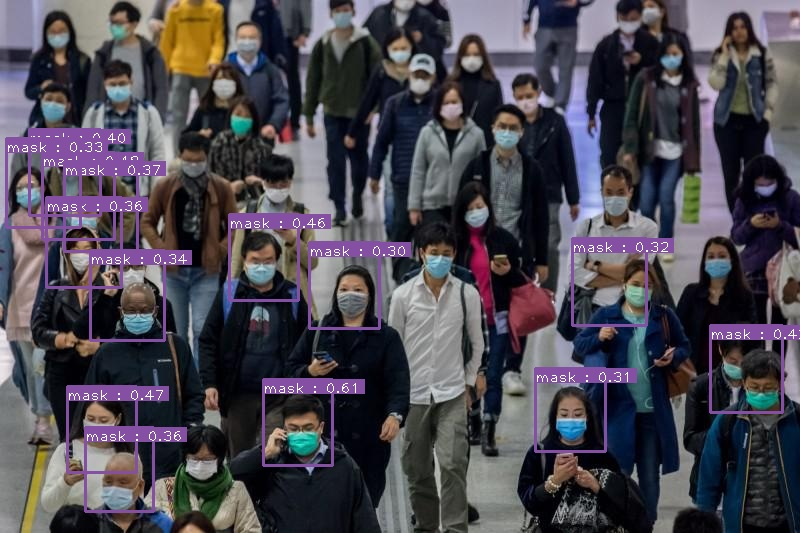

In [29]:
from IPython.display import Image
Image(filename='output.jpg')